In [28]:
# Cell 1: Mount Google Drive and load CSV
from google.colab import drive
import pandas as pd

# Force remount in case drive is already mounted
drive.mount('/content/drive', force_remount=True)

# Define file path (update if different)
file_path = '/content/drive/MyDrive/NetworkIntrusion/Data/cybersecurity_intrusion_data.csv'

# Load CSV into DataFrame
df = pd.read_csv(file_path)

# Basic preview
print("Dataset shape:", df.shape)
df.head()

df.head()

Mounted at /content/drive
Dataset shape: (9537, 11)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [29]:
df['attack_detected'].value_counts(normalize=True)

,proportion
attack_detected,
0,0.552899
1,0.447101


In [30]:
# Step 1: Drop unnecessary column
df = df.drop(columns=['session_id'])

# Step 2: One-hot encode categorical columns
categorical_cols = ['protocol_type', 'encryption_used', 'browser_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 3: Separate features and label
X = df_encoded.drop('attack_detected', axis=1)
y = df_encoded['attack_detected']

# Step 4: Show the updated shape and column info
print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)
X.head()

Feature matrix shape: (9537, 13)
Label vector shape: (9537,)


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Confirm dimensions
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("Training label distribution:\n", y_train.value_counts(normalize=True))
print("Test label distribution:\n", y_test.value_counts(normalize=True))

Training set shape: (7629, 13)
Test set shape: (1908, 13)
Training label distribution:
 attack_detected
0    0.55289
1    0.44711
Name: proportion, dtype: float64
Test label distribution:
 attack_detected
0    0.552935
1    0.447065
Name: proportion, dtype: float64


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate the model
print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest - ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

Random Forest - Confusion Matrix:
[[1052    3]
 [ 215  638]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908

Random Forest - ROC AUC Score: 0.8725524077273965


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Train the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_lr = log_reg.predict(X_test_scaled)

# Evaluate
print("Logistic Regression - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nLogistic Regression - ROC AUC Score:", roc_auc_score(y_test, y_pred_lr))

Logistic Regression - Confusion Matrix:
[[838 217]
 [301 552]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1055
           1       0.72      0.65      0.68       853

    accuracy                           0.73      1908
   macro avg       0.73      0.72      0.72      1908
weighted avg       0.73      0.73      0.73      1908


Logistic Regression - ROC AUC Score: 0.7207202902496347


In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the model
print("KNN - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nKNN - Classification Report:")
print(classification_report(y_test, y_pred_knn))

# ROC AUC
from sklearn.metrics import roc_auc_score
y_probs_knn = knn.predict_proba(X_test_scaled)[:, 1]
print("\nKNN - ROC AUC Score:", roc_auc_score(y_test, y_probs_knn))

KNN - Confusion Matrix:
[[968  87]
 [311 542]]

KNN - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1055
           1       0.86      0.64      0.73       853

    accuracy                           0.79      1908
   macro avg       0.81      0.78      0.78      1908
weighted avg       0.80      0.79      0.79      1908


KNN - ROC AUC Score: 0.8240856080852079


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


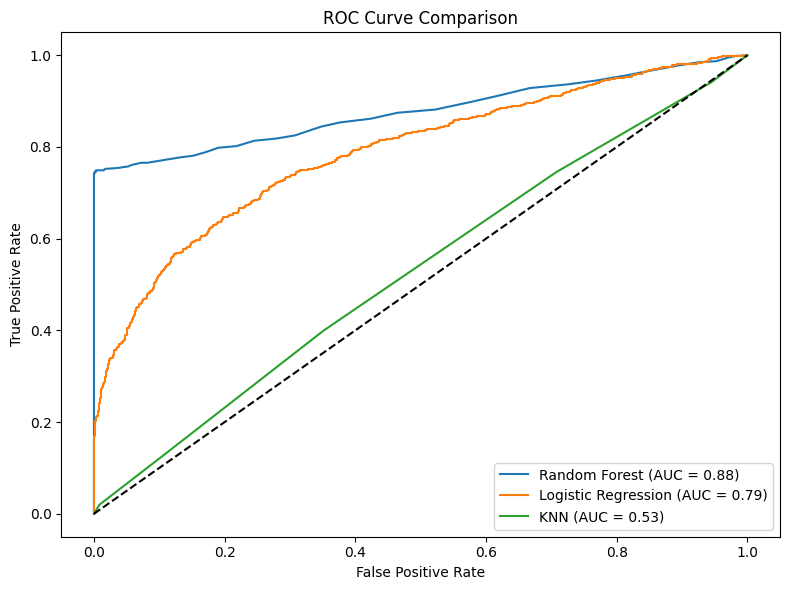

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Fit models and predict probabilities
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_probs_rf = rf.predict_proba(X_test)[:, 1]

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_probs_lr = lr.predict_proba(X_test)[:, 1]

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_probs_knn = knn.predict_proba(X_test)[:, 1]

# ROC curve values
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_probs_knn)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs_rf)))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs_lr)))
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = {:.2f})'.format(roc_auc_score(y_test, y_probs_knn)))
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-37-4073844352.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=auc_scores, y=model_names, palette='viridis')


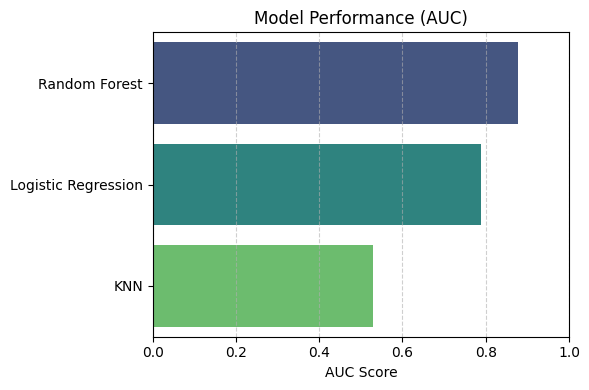

In [37]:
import seaborn as sns

# Define model names and their AUC scores
model_names = ['Random Forest', 'Logistic Regression', 'KNN']
auc_scores = [
    roc_auc_score(y_test, y_probs_rf),
    roc_auc_score(y_test, y_probs_lr),
    roc_auc_score(y_test, y_probs_knn)
]

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=auc_scores, y=model_names, palette='viridis')
plt.xlabel('AUC Score')
plt.title('Model Performance (AUC)')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Store results in a list of dictionaries
results = [
    {
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1 Score': f1_score(y_test, y_pred_rf),
        'AUC': roc_auc_score(y_test, y_probs_rf)
    },
    {
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1 Score': f1_score(y_test, y_pred_lr),
        'AUC': roc_auc_score(y_test, y_probs_lr)
    },
    {
        'Model': 'KNN',
        'Accuracy': accuracy_score(y_test, y_pred_knn),
        'Precision': precision_score(y_test, y_pred_knn),
        'Recall': recall_score(y_test, y_pred_knn),
        'F1 Score': f1_score(y_test, y_pred_knn),
        'AUC': roc_auc_score(y_test, y_probs_knn)
    }
]

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.round(3)  # Optional: round to 3 decimals
summary_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.886,0.995,0.748,0.854,0.877
1,Logistic Regression,0.729,0.718,0.647,0.681,0.788
2,KNN,0.791,0.862,0.635,0.731,0.529


In [44]:
!pip install shap

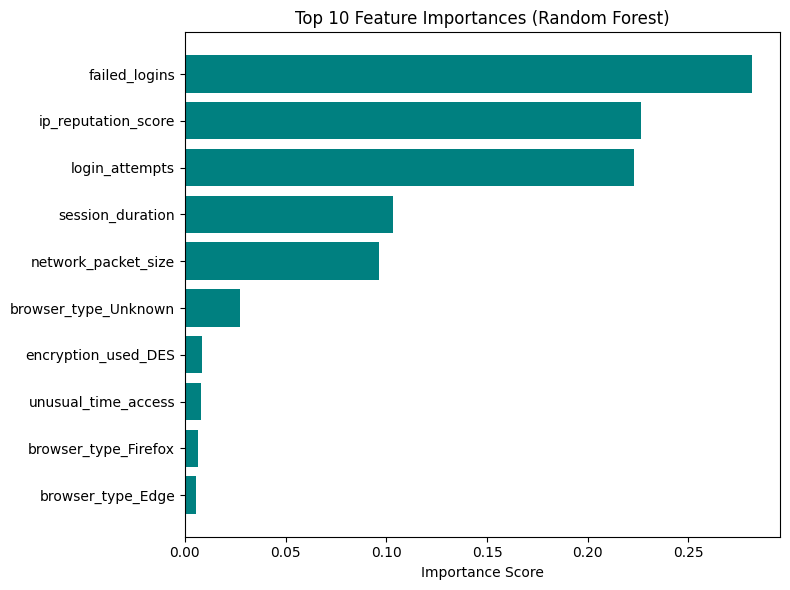

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 features
plt.figure(figsize=(8, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
# Save summary DataFrame to the 'Models' folder
csv_path = "/content/drive/MyDrive/NetworkIntrusion/Models/Model_Comparison_Summary.csv"
summary_df.to_csv(csv_path, index=False)
print(f"Summary saved to: {csv_path}")


Summary saved to: /content/drive/MyDrive/NetworkIntrusion/Models/Model_Comparison_Summary.csv


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Helper function
def get_evaluation_report(model_name, y_true, y_pred):
    report = f"{model_name} - Confusion Matrix:\n"
    report += str(confusion_matrix(y_true, y_pred)) + "\n\n"
    report += f"{model_name} - Classification Report:\n"
    report += classification_report(y_true, y_pred) + "\n"
    return report

# Collect reports
rf_report = get_evaluation_report("Random Forest", y_test, y_pred_rf)
lr_report = get_evaluation_report("Logistic Regression", y_test, y_pred_lr)
knn_report = get_evaluation_report("KNN", y_test, y_pred_knn)

# Combine and save
all_reports = rf_report + "\n" + lr_report + "\n" + knn_report
report_path = "/content/drive/MyDrive/NetworkIntrusion/Models/Model_Evaluation_Reports.txt"

with open(report_path, "w") as f:
    f.write(all_reports)

print(f"Reports saved to: {report_path}")


Reports saved to: /content/drive/MyDrive/NetworkIntrusion/Models/Model_Evaluation_Reports.txt


In [52]:
import os
import joblib

# Define the save path relative to your Google Drive mount
model_dir = '/content/drive/MyDrive/NetworkIntrusion/Models'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the trained models
joblib.dump(rf, os.path.join(model_dir, 'random_forest_model.pkl'))
joblib.dump(log_reg, os.path.join(model_dir, 'logistic_regression_model.pkl'))
joblib.dump(knn, os.path.join(model_dir, 'knn_model.pkl'))

print(f"Models saved to: {model_dir}")

Models saved to: /content/drive/MyDrive/NetworkIntrusion/Models


In [55]:
joblib.dump(scaler, '/content/drive/MyDrive/NetworkIntrusion/Models/scaler.pkl')

['/content/drive/MyDrive/NetworkIntrusion/Models/scaler.pkl']

In [54]:
column_template = X_train.columns
joblib.dump(column_template, '/content/drive/MyDrive/NetworkIntrusion/Models/column_template.pkl')

['/content/drive/MyDrive/NetworkIntrusion/Models/column_template.pkl']